# Applied Algorithms - Home work 4

## Name: Shubham Bhagat   Email: snbhagat@iu.edu   Username: snbhagat

### Partner Name: Shubham Thakur

### All the work herein is solely mine

<hr>

## Problem 1: Expectation-Maximization Algorithm for Clustering

Implement expectation-maximization algorithm for Gaussian mixture models (see the EM algorithm below) in Python and call this program Gk. As you present your code explain your protocol
for
1. initializing each Gaussian
2. deciding ties
3. stopping criteria

The expectation–maximization (EM) algorithm is an iterative approach for determining (local) maximum likelihood or maximum a posteriori (MAP) parameter estimates in statistical models with unobserved latent variables.
- The EM iteration alternates between an expectation (E) step that constructs a function for the expected log-likelihood assessed using the current estimate for the parameters and a maximization (M) phase that computes parameters that maximize the expected log-likelihood discovered on the E step.
- In the following E phase, these parameter estimates are utilized to calculate the distribution of the latent variables.
- For the EM algorithm, we sicuss the following points:

    1. **Initializing each Gaussian**:
       We initialized the Gaussians by randomly picking datapoints from the given dataset. For visualization purposes, below are 3 gausians which are created by considering 3 random points as the initial means and it's respective co-variances. This is for a 1-dimensional dataset.
       
    2. **Deciding Ties**:
       The ties or **likelihood** is calculated using the initialized means and co-variances, and for all the subsequent iterations the means an co-variances are updated in the maximization step.
       
    3. **Stopping Criteria**:
       For the stopping criteria, we define an epsillon value which stops the EM algorithm whenever it converges.
       
       ∑<sup>k</sup><sub>i=1</sub> || µ<sub>i</sub><sup>t</sup> - µ<sub>i</sub><sup>t-1</sup> ||<sup>2</sup>
       
       When the differnece of previous and current means is less than epsillon

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
import random
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [6]:
def em(D, k, eps):
    
    mu, cov_m, priors = [], [], []
    n, d, t = len(D), len(D[0]), 0
    
    # Initialization of mu vectors, covariance matrices and priors
    for _ in range(k):
        random = np.random.randint(0, n)
        mu_vector = D[random]
        cov = np.identity(d)
        mu.append(mu_vector)
        cov_m.append(cov)
        priors.append(1/k)
    
    mu = np.array(mu)
    cov_m = np.array(cov_m)
    priors = np.array(priors)
    max_iter = 50
    
    while t < max_iter:
        
        original_mu = mu.copy()
        t += 1
        posteriors = []
        
         # Expectation step
        for i in range(k):
            likelihoods = np.array([multivariate_normal.pdf(D[j], mean = mu[i], cov = cov_m[i], allow_singular = True) for j in range(n)])
            posterior = likelihoods * priors[i]
            posteriors.append(posterior)

        posteriors = np.array(posteriors)
        posteriors_sums = np.sum(posteriors, axis = 0)
        
        for j in range(n):
            posteriors[:,j] /= posteriors_sums[j]

        # Maximization step

        for i in range(k):
            sum_posteriors_i = 0
            mu[i] = np.zeros(shape = d)
        
            for j in range(n):
                mu[i] += posteriors[i][j] * D[j]
                sum_posteriors_i += posteriors[i][j]
                
            # Calc mean and covariance
            mu[i] /= sum_posteriors_i 
            cov_m[i] = np.zeros(shape = (d,d))
            
            for j in range(n):
                xmu = (D[j] - mu[i]).reshape(-1, 1)
                cov_m[i] += posteriors[i][j] * (xmu @ xmu.T)
                
            cov_m[i] /= sum_posteriors_i
            priors[i] = sum_posteriors_i / n

        diff = [np.square(np.linalg.norm(new_mu - og_mu)) for og_mu, new_mu in zip(original_mu, mu)]      
        stop = np.sum(diff)
        
        if stop <= eps:
            break
    
    return posteriors,t

<hr>

## Problem 2: Analysis of the EM over Real-world Data Sets

Run your EM program, Gk, against the Ringnorm and Ionosphere data sets. Discuss your
results.

• Ringnorm Data Set

• Ionosphere Data Se

 - In this problem I have run the EM algorithm implmented in Problem 1,  20 times for **clusters k = 2, 3, 4, 5.**
 - To calculate the error rates we have first extracted the good and bad labels from the dataset and added their respective errors for each cluster.
 - We report the total error rates and calculate the whisker plot having the **Number of clusters on the y-axis and the iteration counts on the x axis.**

In [26]:
def get_em_preds(posteriors, k_clusters, labels):
    
    predictions = np.argmax(posteriors, axis = 0)
    total_error = 0

    for k in range(k_clusters):
        prediction_indices = np.where(predictions == k)
        specific_labels = labels[prediction_indices]
        
        #classifying 1 as good and 0 as bad labels
        good_labels = specific_labels[specific_labels == 1]
        bad_labels = specific_labels[specific_labels == 0]
        
        n_good_labels = len(good_labels)
        n_bad_labels = len(bad_labels)
        
        if n_good_labels > n_bad_labels:
            cluster_label = 'g'
        else:
            cluster_label = 'b'
            
        # Calc the error rate  
        if cluster_label == 'g':
            error = n_bad_labels/ (n_bad_labels + n_good_labels)
        else:
            error = n_good_labels/ (n_bad_labels + n_good_labels)
        
        total_error += error
    
    print(f'Total error = {total_error}')
    return total_error

In [27]:
def whiskerplot(k, iter_count, error_rate):
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(12, 12)})
    error_rate = np.array(error_rate)
    ax = sns.boxplot(data=error_rate.reshape(20,4), orient='h', width=0.3, palette='pastel')
    ax.set(xlabel="Error rate with respect to Number of Iterations")
    #ax.set(xlabel="Number of Iterations")
    ax.set(ylabel='K clusters')
    ax.set(yticklabels = k)

## Ringnorm dataset

In [88]:
file_name = 'ringnorm.data'
data = np.genfromtxt(file_name)
labels = data[:,-1]
features = data[:,:-1]
clusters = [4, 5]

total_rate_k = []
total_iter = []
runs = 20
eps = 10e-2

#Running the EM algorithm with k = 2,3,4,5 where we do 20 runs for each k
for k in clusters:
    error_rate = [0]*runs
    iter_count = [0]*runs
    print(f'\n=========== k = {k} ================')
    for i in range(runs):
        print(f'Run : {i+1}')
        posteriors,iter_count[i] = em(features, k, eps)
        error_rate[i] = get_em_preds(posteriors, k, labels)
    
    total_rate_k.append(error_rate)
    total_iter.append(iter_count)


=========== k = 4 ================
Run : 1
Total error = 0.16005136454014257
Run : 2
Total error = 0.029148020399635342
Run : 3
Total error = 0.03225735521743785
Run : 4
Total error = 0.05108712296216426
Run : 5
Total error = 0.03259711287030618
Run : 6
Total error = 0.037546376250237705
Run : 7
Total error = 0.035944430350587364
Run : 8
Total error = 0.37735032867274615
Run : 9
Total error = 0.041163413007727793
Run : 10
Total error = 0.03819021120086843
Run : 11
Total error = 0.048285076638656346
Run : 12
Total error = 0.04280924536536234
Run : 13
Total error = 0.03731891257069645
Run : 14
Total error = 0.04267280386280237
Run : 15
Total error = 0.07860155948602855
Run : 16
Total error = 0.4962634305630263
Run : 17
Total error = 0.061178174247158844
Run : 18
Total error = 0.03393819661379627
Run : 19
Total error = 0.039674647517606805
Run : 20
Total error = 0.05645032165332198

=========== k = 5 ================
Run : 1
Total error = 0.03368423731585257
Run : 2
Total error = 0.03703

In [90]:
clusters = [2, 3]
for k in clusters:
    error_rate = [0]*runs
    iter_count = [0]*runs
    print(f'\n=========== k = {k} ================')
    for i in range(runs):
        print(f'Run : {i+1}')
        posteriors,iter_count[i] = em(features, k, eps)
        error_rate[i] = get_em_preds(posteriors, k, labels)
    
    total_rate_k.append(error_rate)
    total_iter.append(iter_count)


=========== k = 2 ================
Run : 1
Total error = 0.06073965417722237
Run : 2
Total error = 0.02928362573099415
Run : 3
Total error = 0.05032305365898364
Run : 4
Total error = 0.05310294170615304
Run : 5
Total error = 0.08900268227261643
Run : 6
Total error = 0.03645677819735956
Run : 7
Total error = 0.045498462098218076
Run : 8
Total error = 0.029761872114813293
Run : 9
Total error = 0.06988244240124962
Run : 10
Total error = 0.02972759259605847
Run : 11
Total error = 0.04972280250476758
Run : 12
Total error = 0.04333422006489938
Run : 13
Total error = 0.039414266349744695
Run : 14
Total error = 0.03448326321565758
Run : 15
Total error = 0.03945765634077322
Run : 16
Total error = 0.748081808615219
Run : 17
Total error = 0.045743730539820684
Run : 18
Total error = 0.03920828996397638
Run : 19
Total error = 0.03473535433266173
Run : 20
Total error = 0.0399120757090697

=========== k = 3 ================
Run : 1
Total error = 0.035533051565631794
Run : 2
Total error = 0.042137075

## Whisker plot for Ringnorm dataset

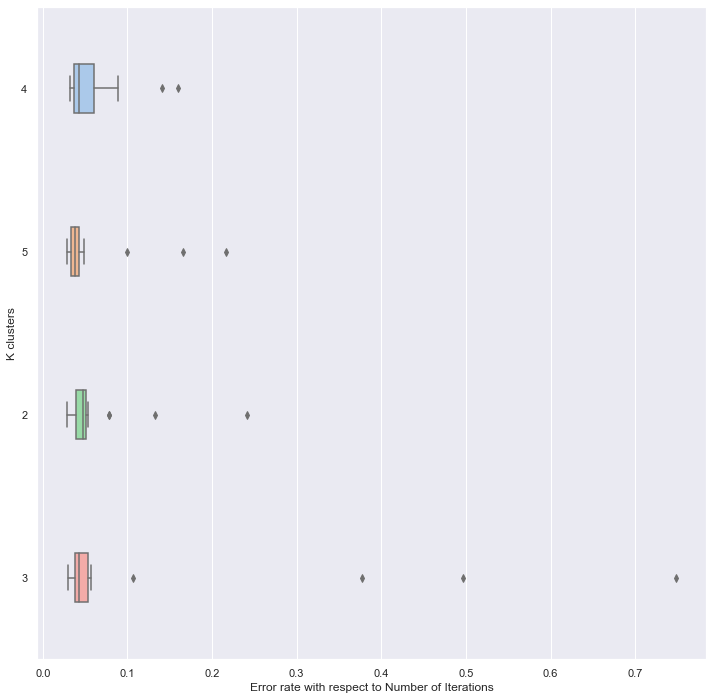

In [114]:
clusters = [4,5,2,3]
whiskerplot(clusters, total_iter, total_rate_k)

##  Ionosphere dataset

In [28]:
file_name = 'ionosphere.data'
data = pd.read_csv(file_name, header = None)
labels = data.iloc[:,0:2]
gb = data.iloc[:,-1]
features_io = data.iloc[:,2:-1]
features_io.columns = [i for i in range(len(features_io.columns))]

In [29]:
def get_em_preds_io(posteriors, k_clusters, labels):
    
    predictions = np.argmax(posteriors, axis = 0)
    total_error = 0
    for k in range(k_clusters):
        prediction_indices = np.where(predictions == k)
        
        # assign labels
        specific_labels = labels[prediction_indices]
        good_labels = specific_labels[specific_labels == 1]
        bad_labels = specific_labels[specific_labels == 0]
        
        n_good_labels = len(good_labels)
        n_bad_labels = len(bad_labels)
        
        if n_good_labels > n_bad_labels:
            cluster_label = 'g'
        else:
            cluster_label = 'b'
            
        # Calc the error rate  
        if cluster_label == 'g':
            error = n_bad_labels/ (n_bad_labels + n_good_labels)
        else:
            error = n_good_labels/ (n_bad_labels + n_good_labels)
        
        total_error += error
    
    print(f'Total error = {total_error}')
    return total_error

In [32]:
labels = [1 if x == 'g' else 0 for x in gb]
labels_df = pd.DataFrame(labels)
labels = labels_df.squeeze()

0      1
1      0
2      1
3      0
4      1
      ..
346    1
347    1
348    1
349    1
350    1
Name: 0, Length: 351, dtype: int64

In [34]:
total_rate_k_io = []
total_iter_io = []
runs = 20
eps = 10e-2
clusters = [2,3,4,5]
#Running the EM algorithm with k = 2,3 where we do 20 runs for each k
for k in clusters:
    error_rate = [0]*runs
    iter_count = [0]*runs
    print(f'\n=========== k = {k} ================')
    for i in range(runs):
        print(f'Run : {i+1}')
        posteriors,iter_count[i] = em(np.array(features_io), k, eps)
        error_rate[i] = get_em_preds_io(posteriors, k, np.array(labels))
    
    total_rate_k_io.append(error_rate)
    total_iter_io.append(iter_count)


=========== k = 2 ================
Run : 1
Total error = 0.34782608695652173
Run : 2
Total error = 0.5791504424778761
Run : 3
Total error = 0.41309754075711524
Run : 4
Total error = 0.3181818181818182
Run : 5
Total error = 0.7378576669112252
Run : 6
Total error = 0.690644932671864
Run : 7
Total error = 0.7271493212669684
Run : 8
Total error = 0.6981886957154289
Run : 9
Total error = 0.24761904761904763
Run : 10
Total error = 0.4992839240959542
Run : 11
Total error = 0.6766938274360979
Run : 12
Total error = 0.7399753531140393
Run : 13
Total error = 0.6561904761904762
Run : 14
Total error = 0.5909090909090909
Run : 15
Total error = 0.21408450704225354
Run : 16
Total error = 0.5779409902494619
Run : 17
Total error = 0.17208299248903103
Run : 18
Total error = 0.5721800116890707
Run : 19
Total error = 0.47728018911287673
Run : 20
Total error = 0.3959509202453988

=========== k = 3 ================
Run : 1
Total error = 0.7024560080442434
Run : 2
Total error = 0.3830392156862745
Run : 3
To

## Whisker plot for Ionosphere dataset

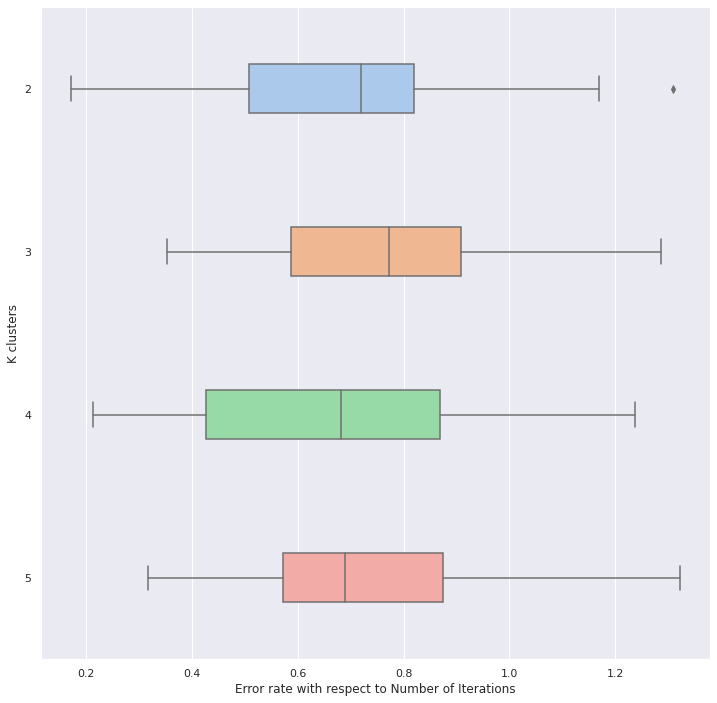

In [35]:
whiskerplot(clusters, total_iter_io, total_rate_k_io)

<hr>

# Problem 3:  Algorithm Design

## Problem 3.1

**Given a text D and a pattern P, describe an Ω(d+p) time method for finding the longest prefix
of P that is a substring of D. The lengths of D and P are d and p, respectively**

For Knuth-Morris-Pratt alogrithm:
* The code calculates the kmp_fail array with size same as the pattern
* The code start the comparison from first index of text and pattern till the last.
* Where there is character mismatch in text and pattern, code checks the failure array and look for the prefix index such that the patter aligns with the mismatch character in the text
* Time complexity of O(n+m)

In [1]:
def compute_kmp_fail(P):
    m = len(P)
    fail = [0] * m
    j = 1
    k = 0
    while j < m:
        if P[j] == P[k]:
            fail[j] = k+1
            j += 1
            k += 1
        elif k > 0:
            k = fail[k-1]
        else:
            j += 1
    return (fail)

def findMatchingPrefix(T, P):
    n, m = len(T), len(P)
    count = 0
    if m == 0:
        return 0
    fail = compute_kmp_fail(P)
    j = 0
    k = 0
    count = 0
    while j < n:
        if T[j] == P[k]:
            if k == m-1:
                return (m, P)
            j += 1
            k += 1
            count = k
        elif k > 0:
            k = fail[k-1]
        else:
            j += 1
    if count == 0:
        return (-1,'')
    else:
        return (count, P[0:count])

In [20]:
Text = "somewhere"
Pattern = "wherever"
T,P = findMatchingPrefix(Text, Pattern)

print(f"The longest prefix of pattern- '{Pattern}' available in text- '{Text}' is '{P}'")

The longest prefix of pattern- 'wherever' available in text- 'somewhere' is 'where'


## Problem 3.2

**X, Y, and Z are three arrays and each has m elements. For an arbitrary integer t, describe O(m2logm)-time algorithm to determine if there exist numbers, x in X, y in Y, and z in Z, such that t = x+y+z.**

Steps:

> &nbsp;&nbsp;Sort the array $z$  
> &nbsp;&nbsp;For each element in $x$  
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;   For each element in $y$  
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  &nbsp;&nbsp;    Calc $zVal$ such that $zVal = t - (x + y)$  
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp;&nbsp;    Search $zVal$ in $z$  
        
The time complexity for the algorithm is **$O(m^2logm)$**

In [3]:
def findTuple(x, y, z, t):
    z.sort()
    res = []

    for i in x:
        for j in y:
            l = 0
            h = len(z) - 1
            zVal = t - (i+j)
            while l <= h:
                m = (l + h) // 2
                if  z[m] == zVal:
                    return (f'There exist a valid tuple in input arrays such that {i} + {j} + {z[m]} = {t}')
                elif zVal > z[m]:
                    l = m + 1
                else:
                    h = m - 1
    return (f'No valid tuple exist in the input arrays such that x+y+z = {t}')

In [4]:
x = [10, 20, 30, 90]
y = [70, 90, 110, 10]
z = [200, 300, 100, 100]
t = 300

print(findTuple(x,y,z,t))

There exist a valid tuple in input arrays such that 10 + 90 + 200 = 300


## Problem 3.3

**Describe an efficient algorithm for deleting a string from a compressed trie and analyze its running time.**

Algorithm steps:

1. Search the $word$ in trie
2. Remove the leaf node corresponding to the word
3. Navigate to the $parent$ of the leaf node in context
4. If the parent has $one$ remaining child:
       Merge the child's value with the parent
       
The time complexity for the delete operation is $O(word\_length)$ where *world_length* corresponds to the length of the word.